# Project Phase 2

Phase 2 of our project.

# Section 2. Compute Agreement Between Annotators

We will use Cohen's Kappa for the compute agreement which is good for cases of two annotators.  The other options of Fleiss' Kappa, Krippendorff's Alpha, and Percentage Agreement do not seem as good of choices in our case.

As a side note, the label 'None' for the column 'pay' had to be changed to 'NoPay' because Pandas was interpreting that as a NaN.  Instead of doing a work around in Pandas, which was possible, I decided to just change the label name to make it easier for others to work with the dataset.

## Cohen's Kappa

For pairwise agreement between two annotators.  We will compute each of the two labels separately, first for 'hire', then for 'pay'.

### Compute for Hire

In [24]:
import pandas as pd
from sklearn.metrics import cohen_kappa_score

# Load the CSV files from the GitHub repository
url_annotator1 = 'https://raw.githubusercontent.com/RyanS974/RyanS974/main/datasets/phase2/zoiya.csv'
url_annotator2 = 'https://raw.githubusercontent.com/RyanS974/RyanS974/main/datasets/phase2/meriem.csv'

# Read the data
annotator1 = pd.read_csv(url_annotator1)
annotator2 = pd.read_csv(url_annotator2)

# Ensure both dataframes are sorted and indexed in the same way
annotator1 = annotator1.sort_values(by="id").reset_index(drop=True)
annotator2 = annotator2.sort_values(by="id").reset_index(drop=True)

# Extract labels
labels_annotator1 = annotator1['hire']
labels_annotator2 = annotator2['hire']

# Compute Cohen's Kappa
kappa_score = cohen_kappa_score(labels_annotator1, labels_annotator2)

# Print the result and interpretation
print(f"Cohen's Kappa Score: {kappa_score:.2f}")

# Interpret the Kappa score
if kappa_score >= 0.75:
    print("Interpretation: Strong agreement")
elif 0.6 <= kappa_score < 0.75:
    print("Interpretation: Moderate agreement")
elif 0.4 <= kappa_score < 0.6:
    print("Interpretation: Fair agreement")
else:
    print("Interpretation: Poor agreement")

Cohen's Kappa Score: 0.68
Interpretation: Moderate agreement


This score is of a moderate agreement between the annotators in the 'hire' column (label).

### Compute for Pay

In [23]:
import pandas as pd
from sklearn.metrics import cohen_kappa_score

# Load the CSV files from the GitHub repository
url_annotator1 = 'https://raw.githubusercontent.com/RyanS974/RyanS974/main/datasets/phase2/zoiya.csv'
url_annotator2 = 'https://raw.githubusercontent.com/RyanS974/RyanS974/main/datasets/phase2/meriem.csv'

# Read the data
annotator1 = pd.read_csv(url_annotator1)
annotator2 = pd.read_csv(url_annotator2)

# Extract labels
labels_annotator1 = annotator1['pay']
labels_annotator2 = annotator2['pay']

# Compute Cohen's Kappa
kappa_score = cohen_kappa_score(labels_annotator1, labels_annotator2)

# Print the result and interpretation
print(f"Cohen's Kappa Score: {kappa_score:.2f}")

# Interpret the Kappa score
if kappa_score >= 0.75:
    print("Interpretation: Strong agreement")
elif 0.6 <= kappa_score < 0.75:
    print("Interpretation: Moderate agreement")
elif 0.4 <= kappa_score < 0.6:
    print("Interpretation: Fair agreement")
else:
    print("Interpretation: Poor agreement")

Cohen's Kappa Score: 0.38
Interpretation: Poor agreement


For the 'pay' column (label) we have a poor agreement between the annotators.

## Interpretation

Even though there is what is rated as 'poor agreement' with our 'pay' label, this is not that bad.  There is a large amount of interpretation ability with that.  The algorithm for Cohen's Kappa is taking into account the large number of NoPay matches and altering the score, I believe.  The score would normally be higher here.  This is the first time I have worked with Cohen's Kappa but I believe that is the explanation.

# Section 3. Determine Ground Truth Labels

Our ground truth labels are the final labels for the dataset.  There are several options available, but the best choice for this case was the 'majority voting' method, which is essentially just a third annotator, myself.

## Majority Voting

I annotated the data as a third annotator which helped resolve any ties.  The full_dataset.csv file is of the final 'ground truth' labels for the dataset.

# Section 4. Analyze Data

The code below using matplotlib mainly will help us analyze the data.  I will comment after the code.

Training set: (600, 6) (600, 2)


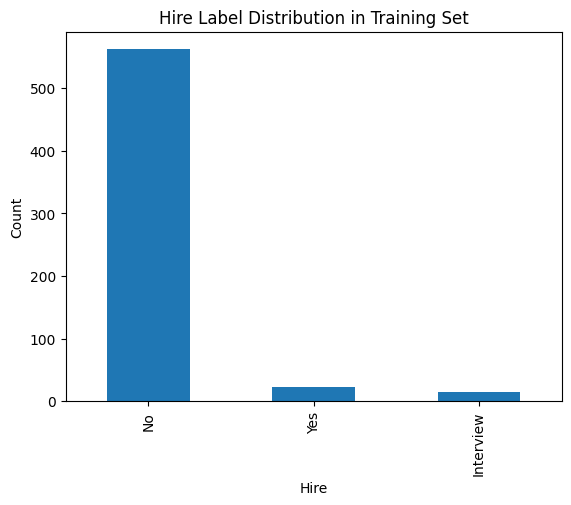

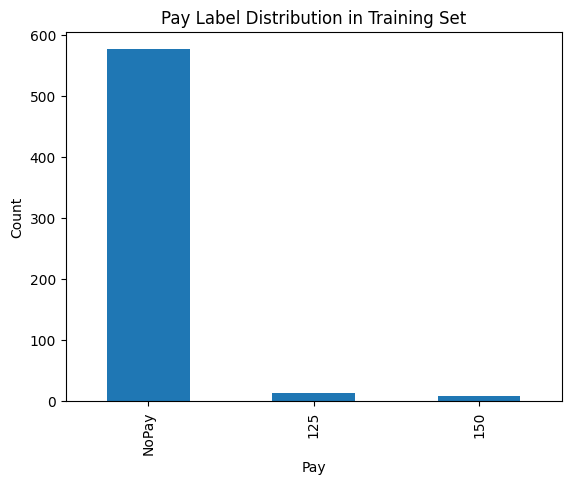

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# column names
column_names = ["id", "skills", "exp", "grades", "projects", "extra", "offer", "hire", "pay"]

# Load training dataset
dataset1 = 'https://raw.githubusercontent.com/RyanS974/RyanS974/main/datasets/phase2/training_set_labeled.csv'
data = pd.read_csv(dataset1, names=column_names).drop(columns=["id"])

# Separate features and labels
X_train = data.drop(columns=["hire", "pay"])  # Features
y_train = data[["hire", "pay"]]  # Multi-label target

# Print shapes to verify
print("Training set:", X_train.shape, y_train.shape)
# Visualize hire label distribution in the training set
hire_counts = y_train['hire'].value_counts()
hire_counts.plot(kind='bar', title='Hire Label Distribution in Training Set')
plt.xlabel('Hire')
plt.ylabel('Count')
plt.show()

# Visualize pay label distribution in the training set (as classification)
pay_counts = y_train['pay'].value_counts()
pay_counts.plot(kind='bar', title='Pay Label Distribution in Training Set')
plt.xlabel('Pay')
plt.ylabel('Count')
plt.show()

This is showing class imbalance, that is somewhat unavoidable in this type of project.  This should be acceptable under these circumstances.  We still have the ability to tune hyperparameters even with the resulting high f1-scores which will be gone over later.  Those scores are in the mid to high 90s due to the class imbalance.

# Section 5. Setup Codabench Page for Task

There are several components in this section, including the baseline model, dummy model, and metrics.  We will start with the task definition.

## Task Definition

CodaBench has a basic Task Definition concept which is given below.

### Actual Task Definition

Task Name: Job Candidate Hiring and Salary Prediction

Objective: Predict whether a candidate will be hired based on their skills, experience, and other features, and estimate their salary if they are hired.

Dataset: The dataset includes information on candidate skills, years of experience, grades, number of completed projects, and involvement in extracurriculars. Labels include "hire" (Yes, No, Interview) and "pay" (125, 150, and NoPay if not hired).

Expected Output: A binary prediction for "hire", along with interview, and if positive, a prediction for "pay."

Evaluation Metrics: Models will be evaluated based on F1-score.

Example Input/Output:

Input: Skills: SQL, Machine Learning, Java; Experience: 3 years; Grades: 92; Projects: 3; Extra: 2
Output: Hire: No, Pay: NoPay

## Load and Split Data

We will work with a 60 40 dataset split, for training and validation / testing.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# column names
column_names = ["id", "skills", "exp", "grades", "projects", "extra", "offer", "hire", "pay"]
column_names2 = ["id", "skills", "exp", "grades", "projects", "extra", "offer"]

# Load the dataset
tsl = 'https://raw.githubusercontent.com/RyanS974/RyanS974/main/datasets/phase2/training_set_labeled.csv'
training_set_labeled = pd.read_csv(tsl, names=column_names).drop(columns=["id"])

vsu = 'https://raw.githubusercontent.com/RyanS974/RyanS974/main/datasets/phase2/validation_set_unlabeled.csv'
validation_set_unlabeled = pd.read_csv(vsu, names=column_names2).drop(columns=["id"])

vsl = 'https://raw.githubusercontent.com/RyanS974/RyanS974/main/datasets/misc/validation_set_labeled.csv'
validation_set_labeled = pd.read_csv(vsl, names=column_names).drop(columns=["id"])

# Separate the features and labels of the training set
X_train = training_set_labeled.drop(training_set_labeled.columns[-2:], axis=1)
y_train = training_set_labeled.iloc[:, -2:]

# There are no labels on the validation set for others to validate their models
X_val = validation_set_unlabeled

# Validation set labeled for internal testing.  Not intended for others to access
y_val = validation_set_labeled.iloc[:, -2:]

# Print shapes to verify
print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape)

Training set: (600, 6) (600, 2)
Validation set: (400, 6)


## Evaluation Metric

We will use f1-score for both 'hire' and 'pay'.  This for both classification labels ("hire" and "pay") is a great choice, especially since it balances precision and recall.

## Baseline Model

We will use a Random Forest classifier for our baseline model, with some basic hyperparameter tuning to make it better than the dummy baseline we will create later.  We will also need to use a multi-label wrapper also since we have two labels.

We will also combine the training, validation, and testing in one code block below, with basic print outs of the f1-scores for validation and testing.

In [26]:
# Import necessary libraries for encoding
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import f1_score

# Initialize CountVectorizer for skills column
vectorizer = CountVectorizer(tokenizer=lambda x: x.split(";"))

# Set up the preprocessor with CountVectorizer for the skills column
preprocessor = ColumnTransformer(
    transformers=[
        ("skills", vectorizer, "skills")
    ],
    remainder="passthrough"  # Keeps the other (numerical) columns as they are
)

# Create a pipeline to combine preprocessing and model training
pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("model", MultiOutputClassifier(RandomForestClassifier(n_estimators=300, max_depth=None, max_features=1.0, random_state=42)))
])

# Train the model on the training set
pipeline.fit(X_train, y_train)

# Make predictions on the validation set
y_val_pred = pipeline.predict(X_val)

# print labels. These are what you submit on CodaLabs in a text file called
# <your_name>.txt
print("Validation predicted values:")
print(y_val_pred)


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Validation predicted values:
[['No' 'NoPay']
 ['No' 'NoPay']
 ['No' 'NoPay']
 ['No' 'NoPay']
 ['No' 'NoPay']
 ['No' 'NoPay']
 ['No' 'NoPay']
 ['No' 'NoPay']
 ['No' 'NoPay']
 ['Interview' 'NoPay']
 ['No' 'NoPay']
 ['No' 'NoPay']
 ['No' 'NoPay']
 ['No' 'NoPay']
 ['No' 'NoPay']
 ['Yes' '125']
 ['No' 'NoPay']
 ['No' 'NoPay']
 ['No' 'NoPay']
 ['No' 'NoPay']
 ['No' 'NoPay']
 ['No' 'NoPay']
 ['Interview' 'NoPay']
 ['No' 'NoPay']
 ['No' 'NoPay']
 ['No' 'NoPay']
 ['No' 'NoPay']
 ['No' 'NoPay']
 ['No' 'NoPay']
 ['No' 'NoPay']
 ['No' 'NoPay']
 ['No' 'NoPay']
 ['No' 'NoPay']
 ['No' 'NoPay']
 ['No' 'NoPay']
 ['No' 'NoPay']
 ['No' 'NoPay']
 ['No' 'NoPay']
 ['No' 'NoPay']
 ['Interview' 'NoPay']
 ['No' 'NoPay']
 ['No' 'NoPay']
 ['Interview' 'NoPay']
 ['No' 'NoPay']
 ['No' 'NoPay']
 ['No' 'NoPay']
 ['No' 'NoPay']
 ['No' 'NoPay']
 ['No' 'NoPay']
 ['No' 'NoPay']
 ['No' 'NoPay']
 ['No' 'NoPay']
 ['No' 'NoPay']
 ['No' 'NoPay']
 ['No' 'NoPay']
 ['No' 'NoPay']
 ['No' 'NoPay']
 ['No' 'NoPay']
 ['No' 'NoPay']


If you modified the hyperparameters here or added more, the last line of code of printing the predictions is printing them in a format that adds some characters, such as brackets. You could still copy and paste this into a text editor and do a standard 'find and replace' to remove these extra characters, or write python code to process this.

### Hyperparameters

Here are the main hyperparameters for the Random Forest classifier we will use:

**n_estimators**: The number of trees directly affects the model's ensemble power. It's usually the first parameter to tune since increasing it improves performance up to a point but with a diminishing return.

**max_depth**: Controlling the tree depth is crucial for managing complexity and preventing overfitting, especially on small or noisy datasets. Shallower trees reduce overfitting, while deeper trees can capture more data nuances.

**max_features**: This parameter impacts diversity across trees. Lower values help create trees that specialize in different parts of the feature space, which generally leads to better generalization.

***In our above baseline model we just trained and evaluated, those settings should be on the higher end for f1-scoring.  In our dummy baseline below, we will use more random and default settings and will give lower scores.***

Our validation metric is f1-score for both classification labels.  This is what the codabench competition is based on.

# Example Scoring and Submission

The scoring will be done on CodaLabs through a scoring script file after you submit the results.  The results are needed to be submitted in the format of "No,Interview" for example.  This is without any quotes in the text file, the quotes are used above to specify the line entry.  This would be one for each line.  The validation set has 400 datapoints so it would be 400.  Some of the other combinations are "Yes,125", etc...

Name this file <your_name>.txt and submit it on the CodaLabs page for this competition, and it will score it on the leaderboard.